In [1]:
import pandas as pd
import datetime
from fbprophet import Prophet
# Upgrade pyplot 
#pip install --upgrade plotly
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet.plot import plot_cross_validation_metric

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Number of days for the prediction

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [2]:
days = 28

## Facebook prophet

We read the data:

In [3]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

We must give the format needed to the dataframe. We need to have a column named `"ds"` with the dates, and a column named `"y"` with the value

In [4]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")

In [5]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

In [6]:
test['ds']

55414    2020-07-26 22:00:00
55415    2020-07-26 23:00:00
55416    2020-07-27 00:00:00
55417    2020-07-27 01:00:00
55418    2020-07-27 02:00:00
                ...         
56081    2020-08-23 17:00:00
56082    2020-08-23 18:00:00
56083    2020-08-23 19:00:00
56084    2020-08-23 20:00:00
56085    2020-08-23 21:00:00
Name: ds, Length: 672, dtype: object

We can now fit the model:

In [7]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Let's check our model. We are going to see what  th metrics are for a cross valdiation on the fitted data. 

In [8]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = str(days)+' days')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2016-07-19 21:00:00 and 2020-06-28 21:00:00


In [9]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [10]:
df_p

horizon         mse       rmse        mae      mape     mdape  \
0    2 days 20:00:00  126.768392  11.259147   8.628030  0.104917  0.071913   
1    2 days 21:00:00  126.997104  11.269299   8.640251  0.103513  0.071459   
2    2 days 22:00:00  126.230281  11.235225   8.621771  0.101953  0.070130   
3    2 days 23:00:00  133.202145  11.541323   8.819098  0.101895  0.071459   
4    3 days 00:00:00  136.136294  11.667746   8.920681  0.103190  0.072040   
..               ...         ...        ...        ...       ...       ...   
600 27 days 20:00:00  204.721953  14.308108  11.495927  0.153230  0.115476   
601 27 days 21:00:00  204.967093  14.316672  11.478991  0.151115  0.113898   
602 27 days 22:00:00  204.366671  14.295687  11.440512  0.148921  0.111005   
603 27 days 23:00:00  209.261007  14.465857  11.537410  0.147816  0.109797   
604 28 days 00:00:00  214.030555  14.629783  11.626310  0.148821  0.109456   

     coverage  
0    0.855776  
1    0.853753  
2    0.855776  
3    0.847498  
4    0.840876  
..        ...  
600  0.769132  
601  0.767660  
602  0.767844  
603  0.764349  
604  0.759566  

[605 rows x 7 columns]

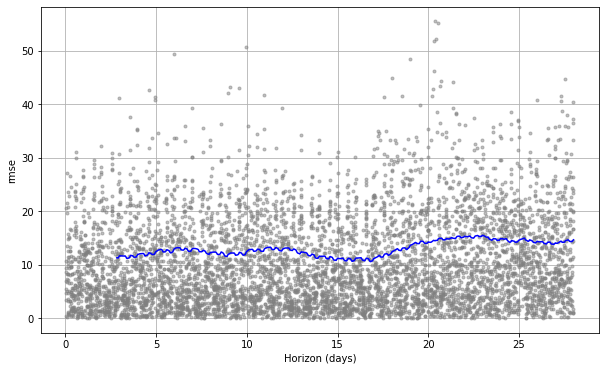

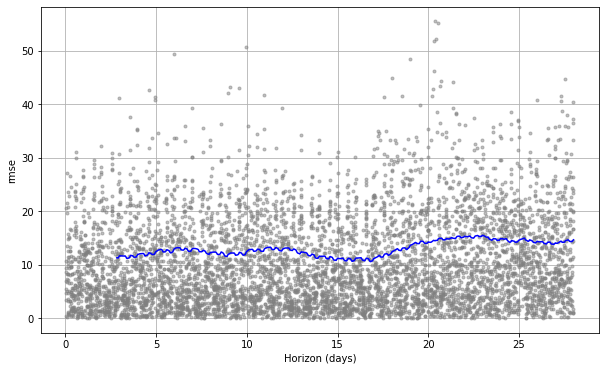

In [11]:
plot_cross_validation_metric(df_cv, metric = 'rmse')

Once we have the metrics for our model, let's predict and check it:

In [12]:
forecast = m.predict(test[['ds']])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
667 2020-08-23 17:00:00  101.826267   85.587755  117.769527
668 2020-08-23 18:00:00  111.789873   95.608774  128.068240
669 2020-08-23 19:00:00  105.415065   89.048752  122.908086
670 2020-08-23 20:00:00   81.091847   64.131446   97.236096
671 2020-08-23 21:00:00   50.491147   32.979855   66.821001

Once we have the predictions, we are having a look at the forecasting:

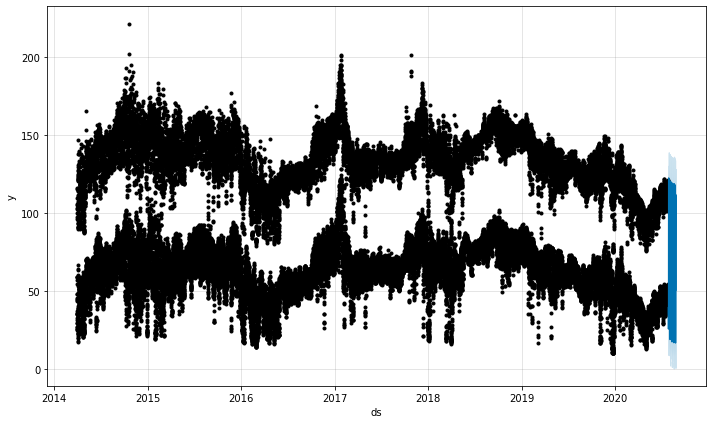

In [13]:
fig1 = m.plot(forecast)

Within the next line, we are seeing the main components from the model:

In [14]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(m, forecast)

There is an interactive option for this library. With the function, using plotly, you can see an interactive plot of the data, where you can select the dates you want to check and it zooms them. The problem is that it gets slow when you use this function, so it will only be used if wanted. For safety, we are keeping it as a markdown cell with the code.

```python
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast[yhat])  # This returns a plotly Figure
py.iplot(fig)
```


Finally, let's check the results

In [15]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0   2020-07-26 22:00:00  62.502002   16.003422   49.086349    62.502002   
1   2020-07-26 23:00:00  62.499061    8.791467   44.385354    62.499061   
2   2020-07-27 00:00:00  62.496120   10.675082   45.744962    62.496120   
3   2020-07-27 01:00:00  62.493179   13.418960   47.277403    62.493179   
4   2020-07-27 02:00:00  62.490238   11.594456   45.435303    62.490238   
..                  ...        ...         ...         ...          ...   
667 2020-08-23 17:00:00  60.540289   85.587755  117.769527    60.277541   
668 2020-08-23 18:00:00  60.537348   95.608774  128.068240    60.273325   
669 2020-08-23 19:00:00  60.534407   89.048752  122.908086    60.269110   
670 2020-08-23 20:00:00  60.531466   64.131446   97.236096    60.264894   
671 2020-08-23 21:00:00  60.528525   32.979855   66.821001    60.260678   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      62.502002      -29.802298            -29.802298            -29.802298   
1      62.499061      -36.980830            -36.980830            -36.980830   
2      62.496120      -34.728440            -34.728440            -34.728440   
3      62.493179      -32.525526            -32.525526            -32.525526   
4      62.490238      -34.349121            -34.349121            -34.349121   
..           ...             ...                   ...                   ...   
667    60.788155       41.285978             41.285978             41.285978   
668    60.787416       51.252525             51.252525             51.252525   
669    60.786244       44.880658             44.880658             44.880658   
670    60.784989       20.560381             20.560381             20.560381   
671    60.783734      -10.037378            -10.037378            -10.037378   

         daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0   -28.731766  ... -2.784364     -2.784364     -2.784364  1.713832   
1   -36.256934  ... -2.427179     -2.427179     -2.427179  1.703283   
2   -34.353588  ... -2.067581     -2.067581     -2.067581  1.692729   
3   -32.499676  ... -1.708019     -1.708019     -1.708019  1.682169   
4   -34.669824  ... -1.350902     -1.350902     -1.350902  1.671604   
..         ...  ...       ...           ...           ...       ...   
667  46.252909  ... -4.448393     -4.448393     -4.448393 -0.518538   
668  55.909885  ... -4.139832     -4.139832     -4.139832 -0.517528   
669  49.213994  ... -3.816808     -3.816808     -3.816808 -0.516528   
670  24.557546  ... -3.481626     -3.481626     -3.481626 -0.515539   
671  -6.386150  ... -3.136667     -3.136667     -3.136667 -0.514561   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        1.713832      1.713832                   0.0   
1        1.703283      1.703283                   0.0   
2        1.692729      1.692729                   0.0   
3        1.682169      1.682169                   0.0   
4        1.671604      1.671604                   0.0   
..            ...           ...                   ...   
667     -0.518538     -0.518538                   0.0   
668     -0.517528     -0.517528                   0.0   
669     -0.516528     -0.516528                   0.0   
670     -0.515539     -0.515539                   0.0   
671     -0.514561     -0.514561                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   32.699705  
1                           0.0                         0.0   25.518231  
2                           0.0                         0.0   27.767680  
3                           0.0                         0.0   29.967653  
4                           0.0                         0.0   28.141116  
..                          ...                         ...         ...  
667                         0.0                         0.0  101.826267  
668                         0

Checking the forecasting for the last days:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  16.612492104400676 , un R2 de  0.7626520311459004  y un MAPE de 23.358023037339162


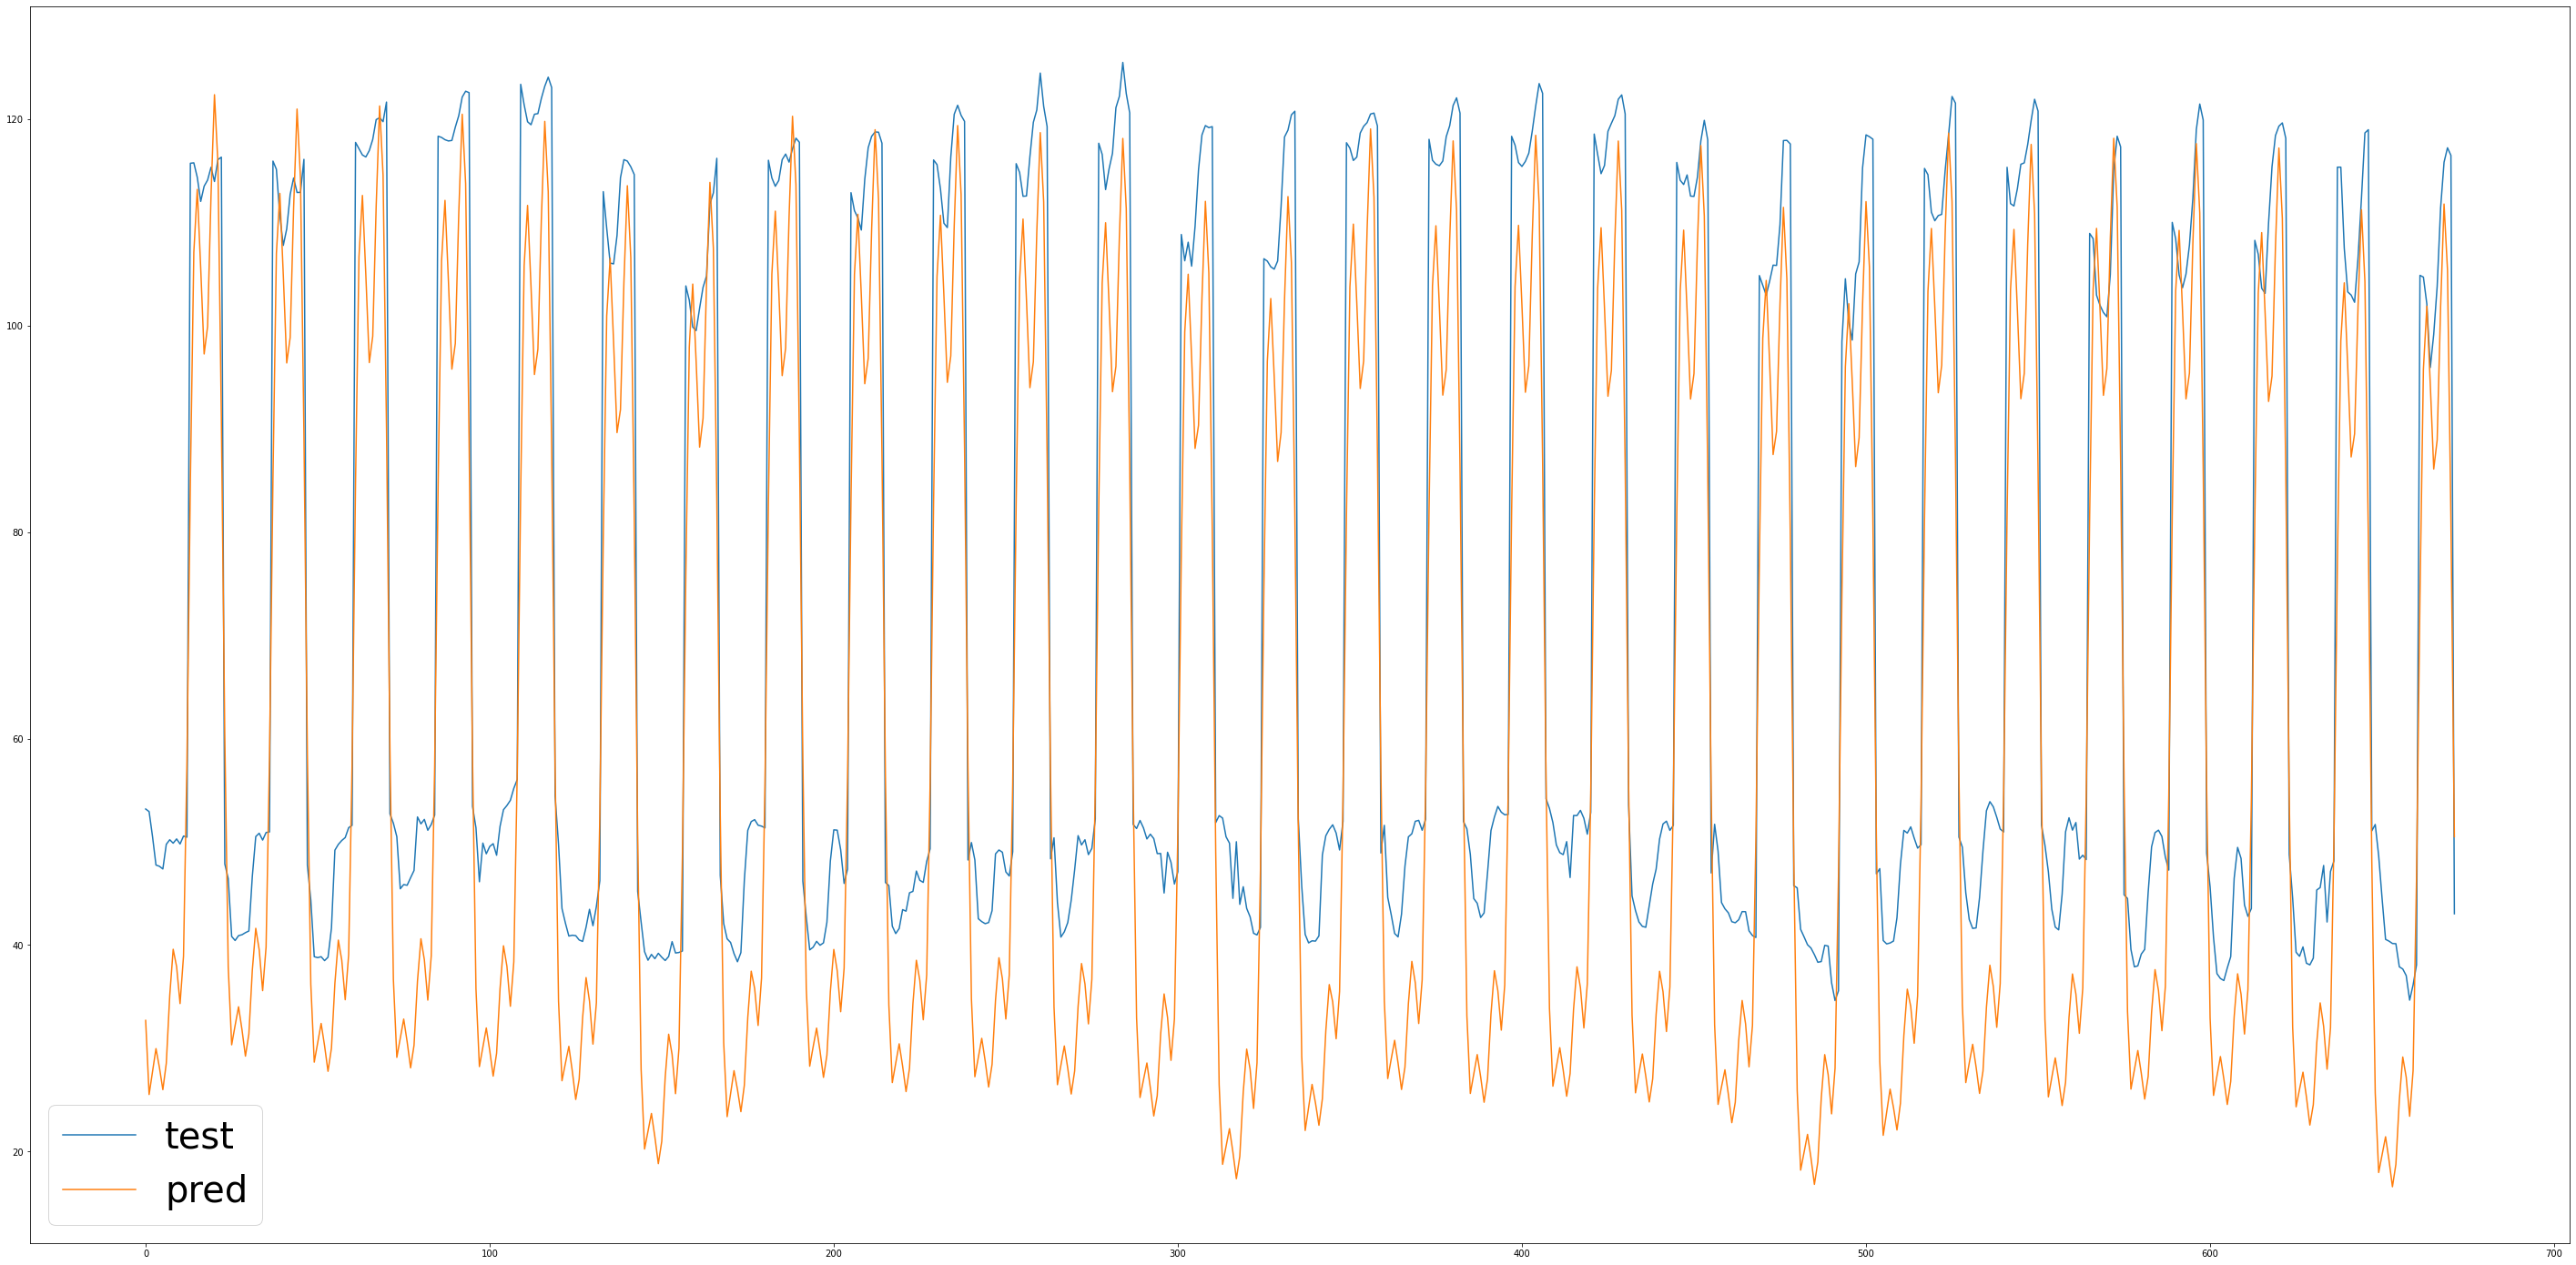

In [16]:
# Let's plot the results and check the metrics.
y_test_days = test['y'].copy()
y_pred_days = forecast['yhat'].copy()
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test_days, y_pred_days)),', un R2 de ',r2_score(y_test_days, y_pred_days),' y un MAPE de',mean_absolute_percentage_error(y_test_days, y_pred_days))
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(test['y'].reset_index().drop('index',axis=1), label='test')
plt.plot(forecast['yhat'], label='pred')
plt.legend(prop={'size': 40})
plt.show()

Finally, we export the results for the visualization

In [17]:
pd.DataFrame({'test':test['y'].values, 'prediccion':forecast['yhat'].values},index = test['ds'].values).to_csv('./../Visualization/Facebook_prophet.csv')

## SARIMAX

First, we read the data:

In [18]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

We can recycle the code from the FP model so we give our data the format needed:

In [19]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")
# Finally we set again ds as index:
new_df = new_df.set_index('ds')

In [20]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

Before we fit the model, as we said in the document from the project, we are using **auto_arima** so we can find the best model for our data. As it takes quite a lot of time to find the best model, we are just plotting the code used and the results obtained. It is important to say that, to avoid crashing, we reduced the size of the train data from April 2014 to January 2016.

>```python
train = train.loc['2016-01-01 00:00:00':]
start = new_df.index.get_loc('2016-01-01 00:00:00')
```

>```python
import pmdarima as pm
model = pm.auto_arima(
    train,
    stationary = False,
    m=12,
    n_jobs = -1,
    exogenous = df.iloc[start:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-start-last_value,1),
    suppress_warnings=True
)
```

>```python
model.summary()
```

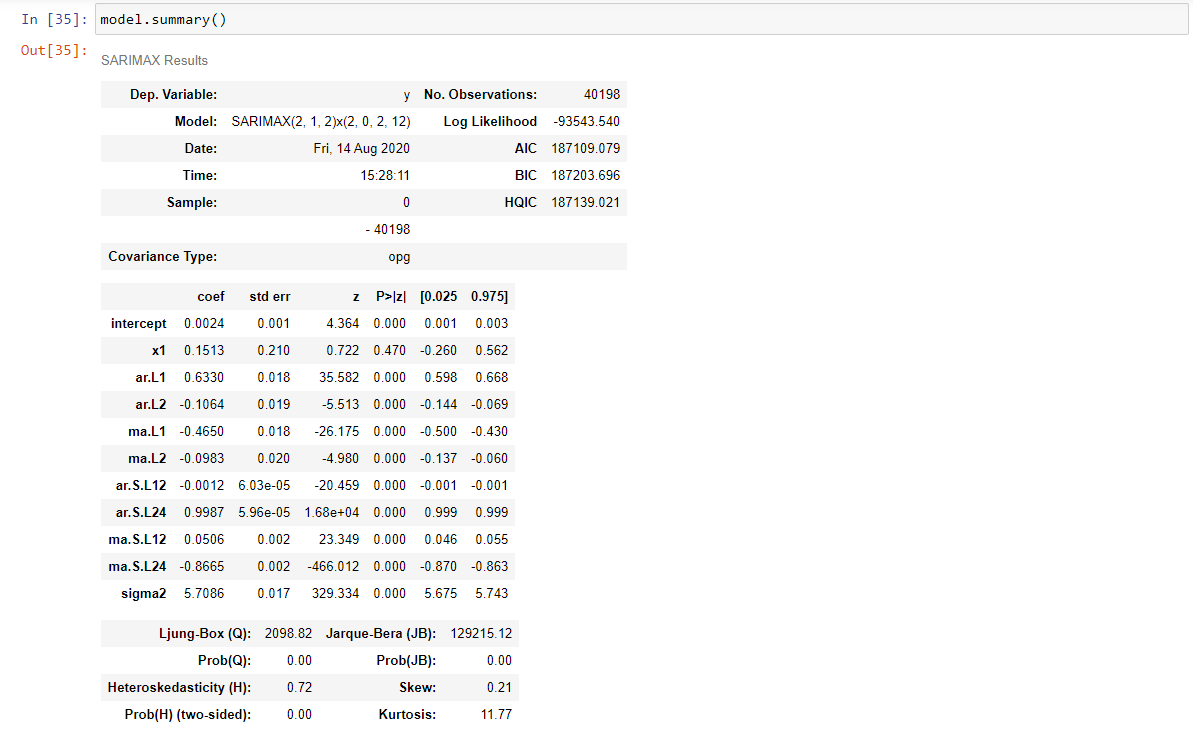

So, we fit the model with those hyperparameters:

In [21]:
model2 = SARIMAX(train, 
                 order = (2, 1, 2), 
                 seasonal_order = (2, 0, 2, 12),
                 exog = df.iloc[:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-24*days,1)
                ).fit()

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [22]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                55414
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood             -133125.763
Date:                            Fri, 04 Sep 2020   AIC                         266271.526
Time:                                    21:17:18   BIC                         266360.752
Sample:                                04-01-2014   HQIC                        266299.343
                                     - 07-26-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3980      0.090      4.407      0.000       0.221       0.575
ar.L1          0.9246      0.017     55.887      0.000       0.892       0.957
ar.L2          0.0052      0.016      0.332      0.740      -0.026       0.036
ma.L1         -0.8173      0.016    -50.448      0.000      -0.849      -0.786
ma.L2         -0.1811      0.016    -11.182      0.000      -0.213      -0.149
ar.S.L12      -0.0009    4.6e-05    -20.256      0.000      -0.001      -0.001
ar.S.L24       0.9990   4.74e-05   2.11e+04      0.000       0.999       0.999
ma.S.L12       0.0256      0.002     12.487      0.000       0.022       0.030
ma.S.L24      -0.8502      0.002   -518.760      0.000      -0.853      -0.847
sigma2         7.1476      0.021    341.961      0.000       7.107       7.189
===================================================================================
Ljung-Box (Q):                     1908.88   Jarque-Bera (JB):            105784.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can plot the train and the fitted values so we know how our model performs in the train data:

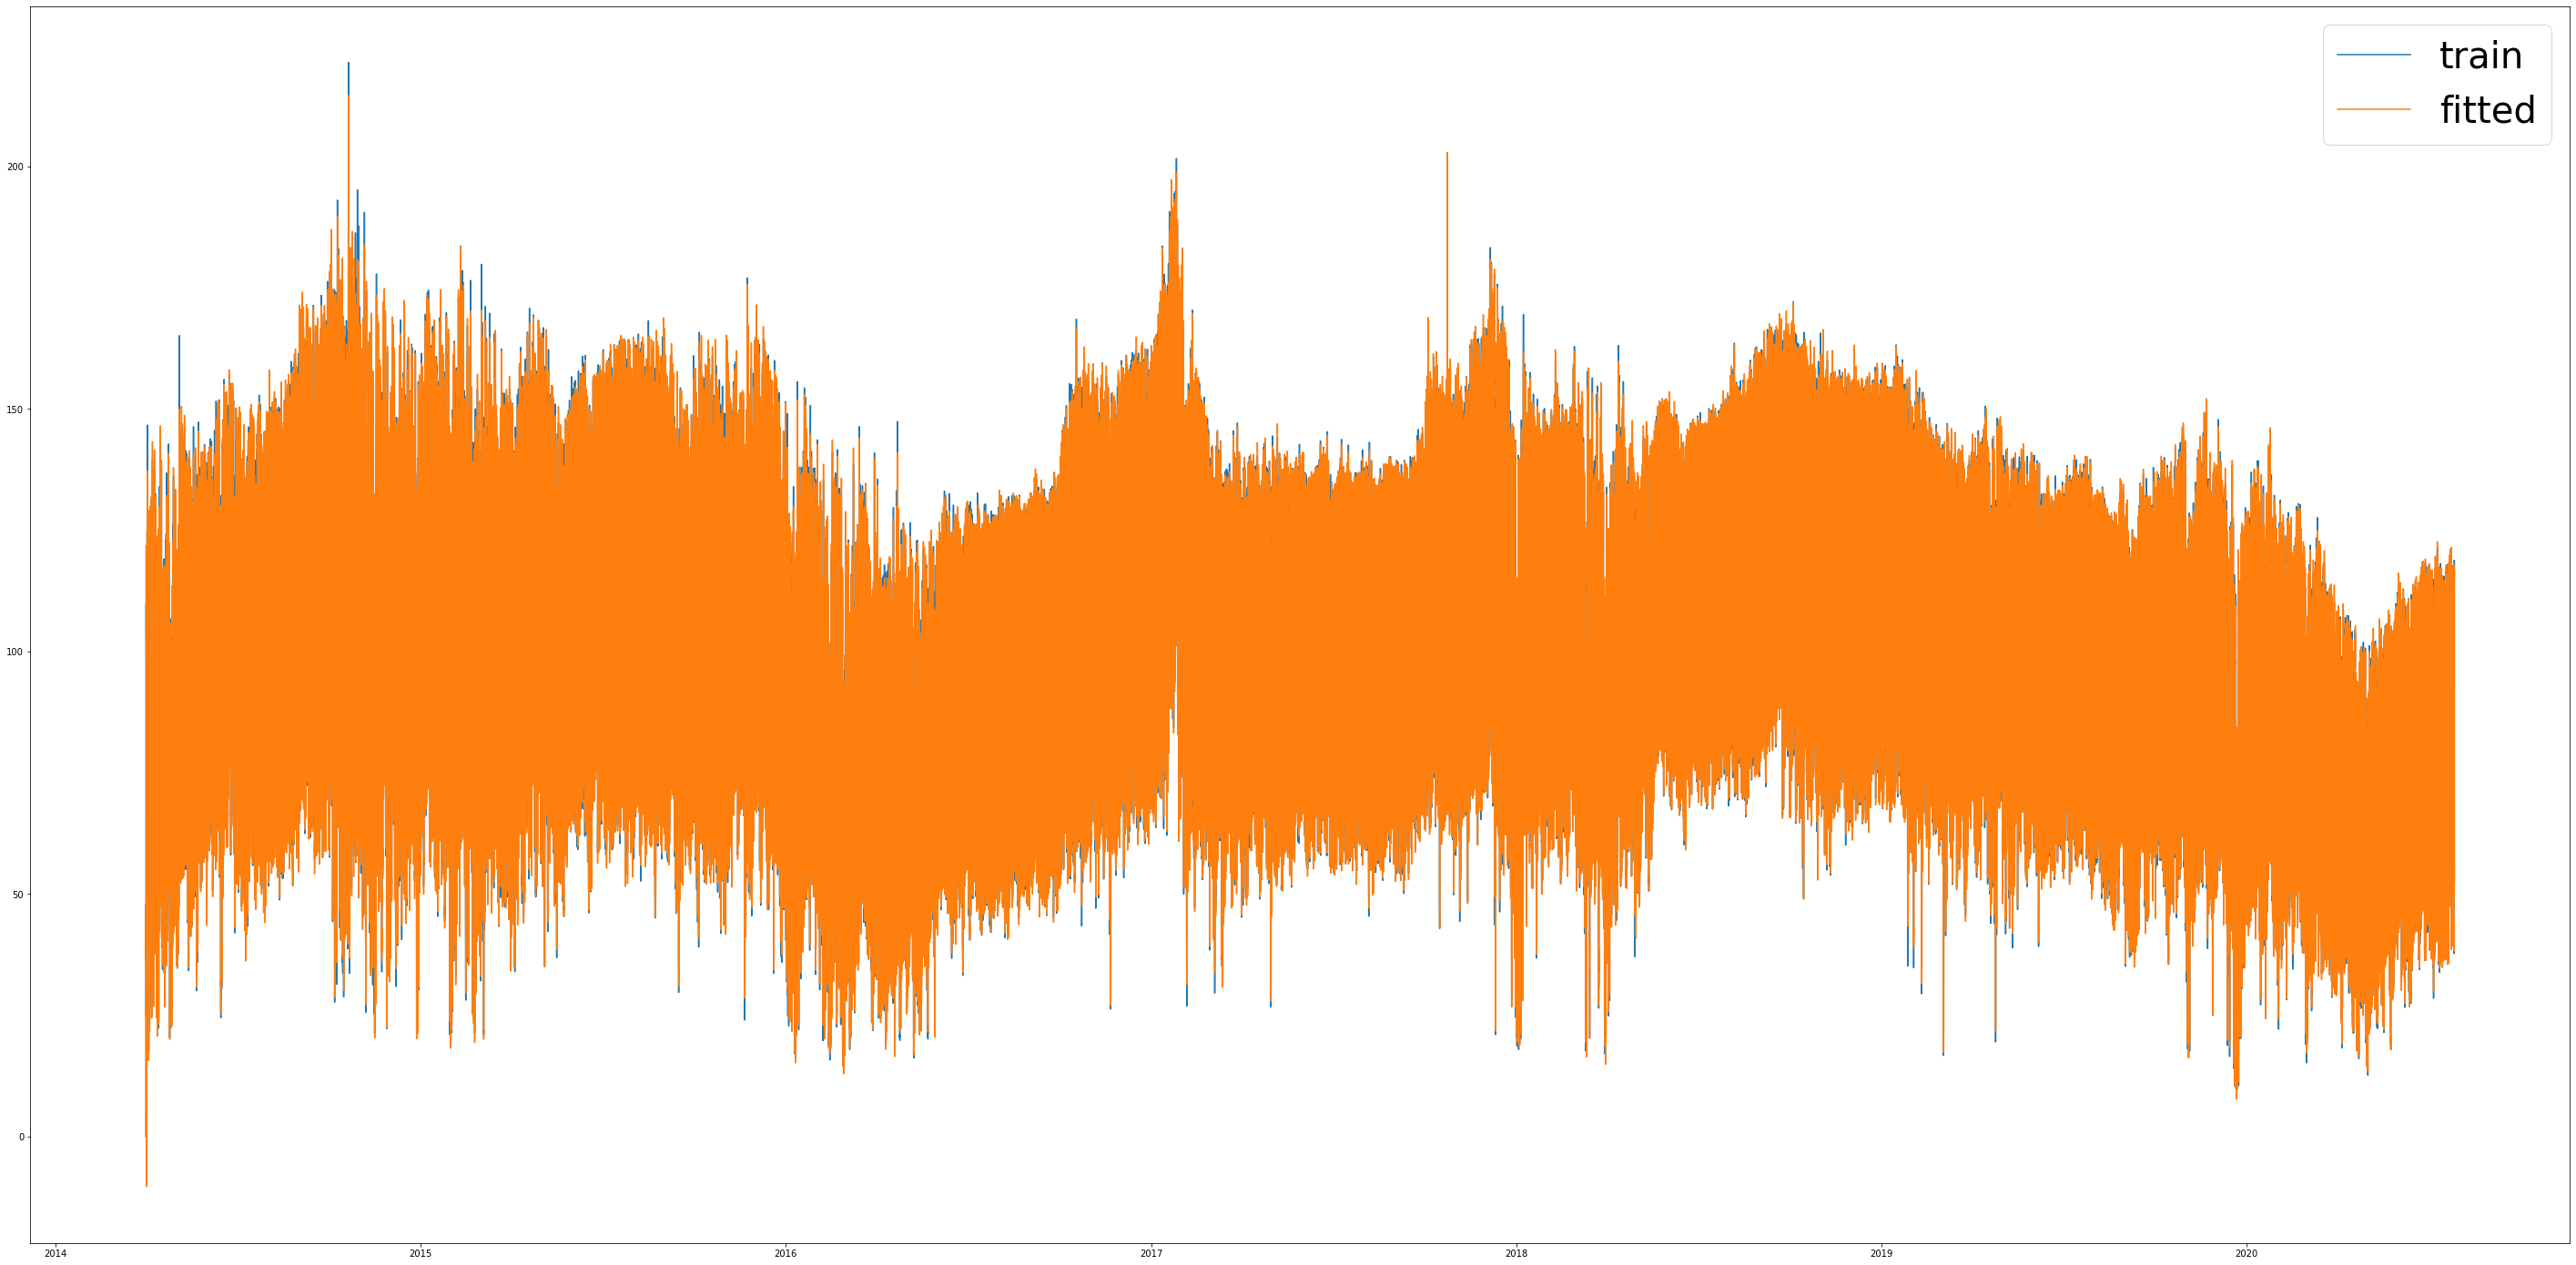

In [23]:
#Let's parse dates:
train.index = pd.to_datetime(train.index)
fitted_values = pd.Series(model2.fittedvalues)
fitted_values.index = pd.to_datetime(fitted_values.index)
# Let's plot both series:
plt.plot(train['y'], label='train')
plt.plot(fitted_values, label='fitted')
plt.legend(prop={'size': 40})

Let's predict the values for the number of hours and days selected before:

In [26]:
forecast_mean2 = model2.forecast(24*days, 
                                 exog = df.iloc[last_value:,list(df.columns).index('holidays')].values.reshape(24*days,1), 
                                 return_conf_int = True)
forecast_mean2

2020-07-26 22:00:00     53.158233
2020-07-26 23:00:00     48.542643
2020-07-27 00:00:00     46.223511
2020-07-27 01:00:00     46.569413
2020-07-27 02:00:00     46.266533
                          ...    
2020-08-23 17:00:00    116.826998
2020-08-23 18:00:00    118.154114
2020-08-23 19:00:00    119.364243
2020-08-23 20:00:00    120.015965
2020-08-23 21:00:00     53.579833
Freq: H, Length: 672, dtype: float64

Let's check the predictions:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  5.27170650477959 , un R2 de  0.9760988723456256  y un MAPE de 7.028069078558143


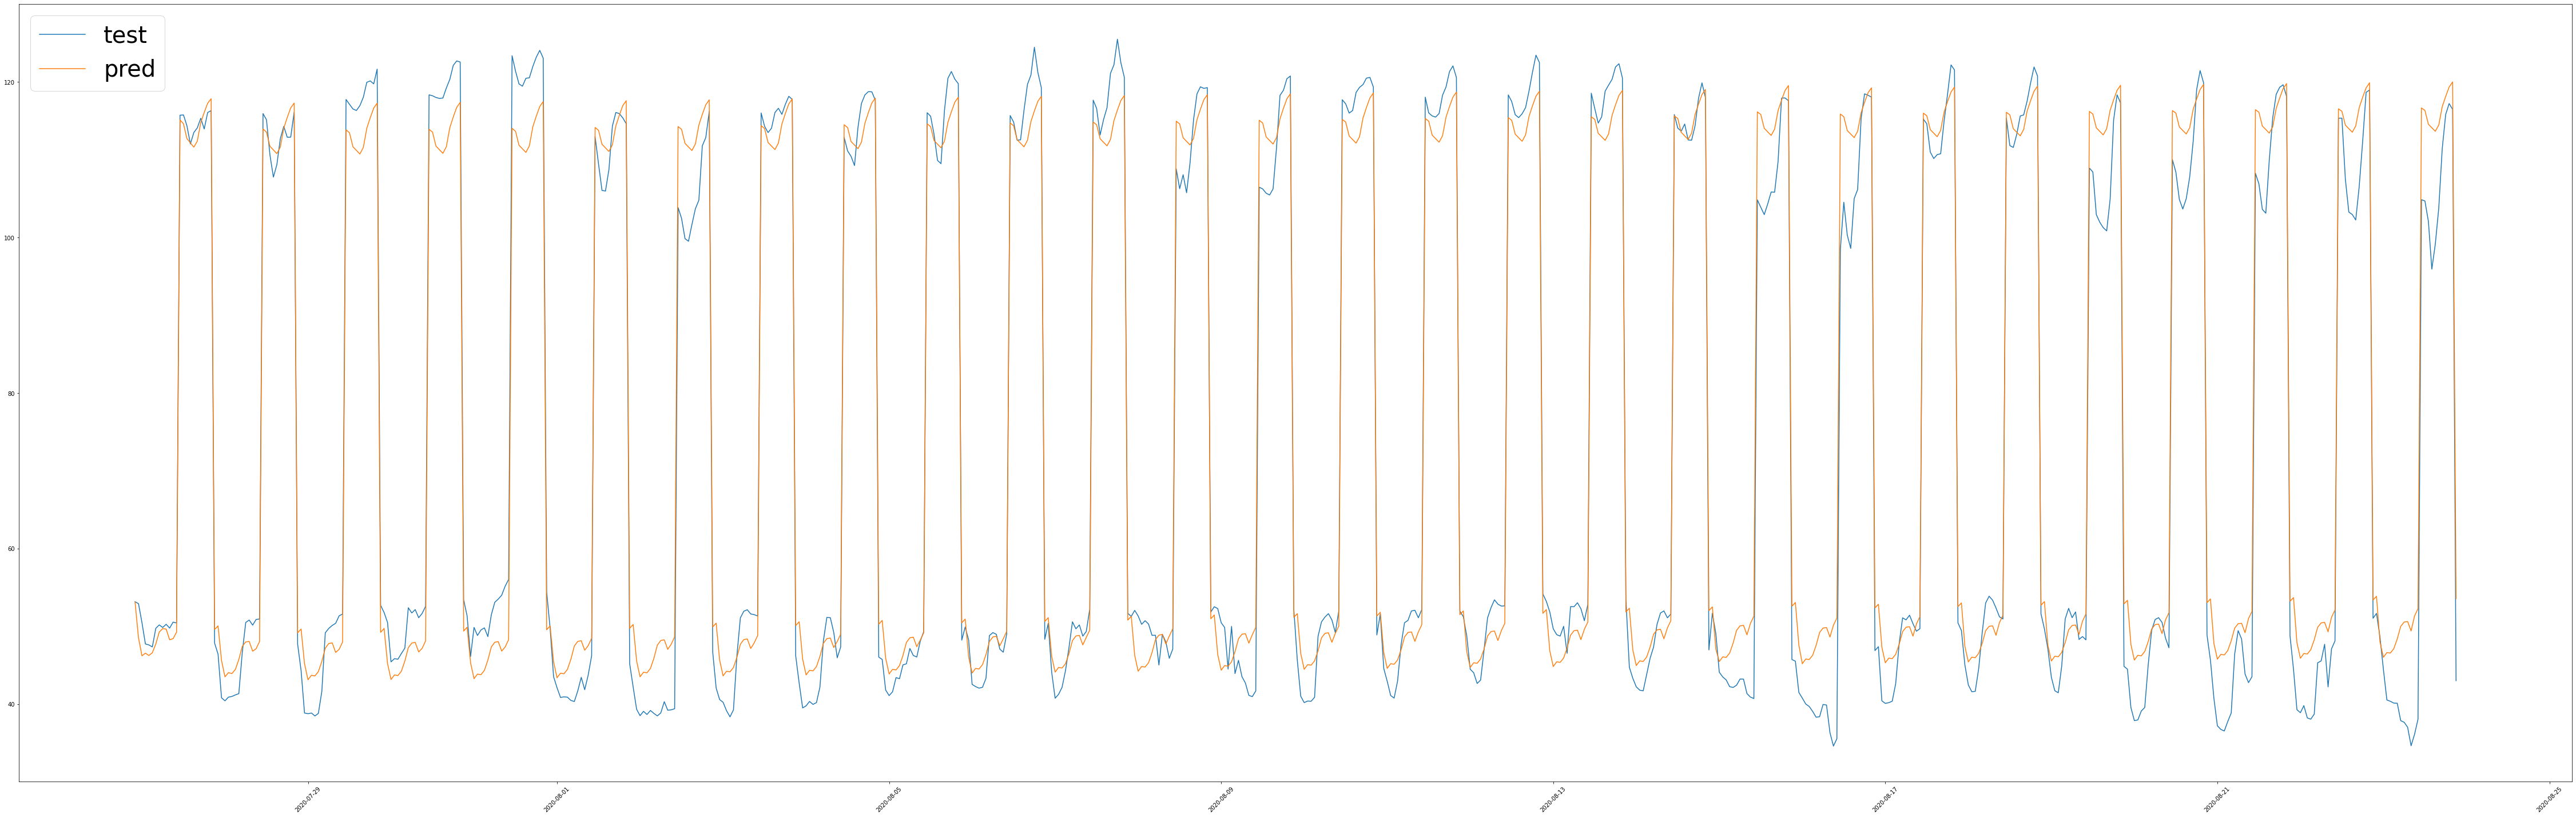

In [28]:
# Let's define the variables:
y_test = test['y']
y_pred = pd.Series(forecast_mean2, index=forecast_mean2.index)
y_test.index =  pd.to_datetime(y_test.index)
y_pred.index =  pd.to_datetime(y_pred.index)
# Now we print the metrics
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))
# Finally we plot the results:
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=45, fontsize = 10)
plt.show()

Finally, we export the results for the visualization

In [29]:
pd.DataFrame({'test':y_test, 'prediccion': y_pred},index = test.index).to_csv('./../Visualization/SARIMAX.csv')